In [1]:
import os

#data_dir = os.path.join(os.getenv("HOME"), "work/ocr/data")
data_dir = "./data"
#os.chdir(data_dir)  #커서 이동 !cd data_dir

In [2]:
NUMBERS = "0123456789"
ENG_CHAR_UPPER = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
TARGET_CHARACTERS = ENG_CHAR_UPPER + NUMBERS
print(f"The total number of characters is {len(TARGET_CHARACTERS)}")

The total number of characters is 36


In [3]:
import re
import six
import math
import lmdb
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from IPython.display import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

TRAIN_DATA_PATH = data_dir + '/MJ/MJ_train'
VALID_DATA_PATH = data_dir + '/MJ/MJ_valid'
TEST_DATA_PATH  = data_dir + '/MJ/MJ_test'

print(TRAIN_DATA_PATH)

Using device: cuda
./data/MJ/MJ_train


## 5.Recognition model (2) Input Image

original image width:72, height:31
target_img_size:(74, 32)
display img shape:(74, 32, 3)
label:Lube


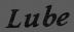

original image width:82, height:31
target_img_size:(84, 32)
display img shape:(84, 32, 3)
label:Spencerian


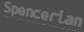

original image width:115, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:accommodatingly


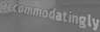

original image width:140, height:31
target_img_size:(100, 32)
display img shape:(100, 32, 3)
label:CARPENTER


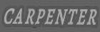

In [4]:
from IPython.display import display

# env에 데이터를 불러올게요
# lmdb에서 데이터를 불러올 때 env라는 변수명을 사용하는게 일반적이에요
env = lmdb.open(TRAIN_DATA_PATH,
                max_readers=32,
                readonly=True,
                lock=False,
                readahead=False,
                meminit=False)

# 불러온 데이터를 txn(transaction)이라는 변수를 통해 엽니다
# 이제 txn변수를 통해 직접 데이터에 접근 할 수 있어요
with env.begin(write=False) as txn:
    for index in range(1, 5):
        # index를 이용해서 라벨 키와 이미지 키를 만들면
        # txn에서 라벨과 이미지를 읽어올 수 있어요
        label_key = 'label-%09d'.encode() % index
        label = txn.get(label_key).decode('utf-8')
        img_key = 'image-%09d'.encode() % index
        imgbuf = txn.get(img_key)
        buf = six.BytesIO()
        buf.write(imgbuf)
        buf.seek(0)

        # 이미지는 버퍼를 통해 읽어오기 때문에
        # 버퍼에서 이미지로 변환하는 과정이 다시 필요해요
        try:
            img = Image.open(buf).convert('RGB')

        except IOError:
            img = Image.new('RGB', (100, 32))
            label = '-'

        # 원본 이미지 크기를 출력해 봅니다
        width, height = img.size
        print('original image width:{}, height:{}'.format(width, height))

        # 이미지 비율을 유지하면서 높이를 32로 바꿀거에요
        # 하지만 너비를 100보다는 작게하고 싶어요
        target_width = min(int(width*32/height), 100)
        target_img_size = (target_width,32)
        print('target_img_size:{}'.format(target_img_size))
        img = np.array(img.resize(target_img_size)).transpose(1,0,2)

        # 이제 높이가 32로 일정한 이미지와 라벨을 함께 출력할 수 있어요
        print('display img shape:{}'.format(img.shape))
        print('label:{}'.format(label))
        display(Image.fromarray(img.transpose(1,0,2).astype(np.uint8)))

In [5]:
class MJDataset(Dataset):
    # 객체를 초기화 할 때 lmdb를 열어 env에 준비해둡니다
    # 또, lmdb에 있는 데이터 수를 미리 파악해둡니다
    def __init__(
        self,
        dataset_path,
        label_converter,
        img_size=(100, 32),
        max_text_len=22,
        character="",
    ):
        super().__init__()
        self.label_converter = label_converter
        self.img_size = img_size
        self.max_text_len = max_text_len
        self.character = character

        # lmdb open
        self.env = lmdb.open(dataset_path,max_readers=32,readonly=True,lock=False,readahead=False,meminit=False)
        with self.env.begin(write=False) as txn:
            self.num_samples = int(txn.get("num-samples".encode()))
            self.index_list = [idx + 1 for idx in range(self.num_samples)]

    def __len__(self):
        return self.num_samples

    # index에 해당하는 image와 label을 읽어옵니다
    # 위에서 사용한 코드와 매우 유사합니다
    # label을 조금 더 다듬는 것이 약간 다릅니다
    def __getitem__(self, idx):
        index = self.index_list[idx]
        with self.env.begin(write=False) as txn:
            label_key = f"label-{index:09d}".encode()
            label = txn.get(label_key).decode("utf-8")

            img_key = f"image-{index:09d}".encode()
            imgbuf = txn.get(img_key)

            buf = six.BytesIO()
            buf.write(imgbuf)
            buf.seek(0)

            try:
                img_pil = Image.open(buf).convert("RGB")
            except IOError:
                img_pil = Image.new("RGB", self.img_size)
                label = "-"

        orig_w, orig_h = img_pil.size
        target_width = min(int(orig_w * self.img_size[1] / orig_h), self.img_size[0])
        target_img_size = (target_width, self.img_size[1])
        img_pil = img_pil.resize(target_img_size)

        img = np.array(img_pil)
        img = img.transpose(2, 0, 1)

        padded_img = np.zeros((3, self.img_size[1], self.img_size[0]), dtype=np.float32)
        c, h, w = img.shape
        padded_img[:, :h, :w] = img

        # 레이블 전처리
        label = label.upper()
        out_of_char = f"[^{self.character}]"
        label = re.sub(out_of_char, "", label)
        label = label[: self.max_text_len]

        encoded_label = self.label_converter.encode(label)

        return padded_img, encoded_label, len(encoded_label), label


In [6]:
def collate_fn(batch):
    imgs, encoded_labels, label_lens, raw_labels = zip(*batch)

    imgs_tensor = torch.tensor(np.stack(imgs, axis=0), dtype=torch.float32)

    max_len = max(label_lens)
    labels_padded = torch.zeros(len(batch), max_len, dtype=torch.long)
    for i, label_arr in enumerate(encoded_labels):
        length = label_lens[i]
        labels_padded[i, :length] = torch.tensor(label_arr, dtype=torch.long)

    batch_size = imgs_tensor.size(0)
    # 여기서는 크기 24로 가정
    input_length = torch.full(size=(batch_size,), fill_value=24, dtype=torch.long)
    label_length = torch.tensor(label_lens, dtype=torch.long)

    return (
        imgs_tensor,
        labels_padded,
        input_length,
        label_length,
        raw_labels,  # 디버깅용
    )

## 6. Recognition model (3) Encode

In [7]:
class LabelConverter(object):

     def __init__(self, character):
         self.character = "-" + character
         self.label_map = dict()
         for i, char in enumerate(self.character):
             self.label_map[char] = i

     def encode(self, text):
         encoded_label = []
         for i, char in enumerate(text):
             if i > 0 and char == text[i - 1]:
                 encoded_label.append(0)    # 같은 문자 사이에 공백 문자 label을 삽입
             encoded_label.append(self.label_map[char])
         return np.array(encoded_label, dtype=np.int32)

     def decode(self, encoded_label):
         target_characters = list(self.character)
         decoded_label = ""
         for encode in encoded_label:
             decoded_label += self.character[encode]
         return decoded_label
print("슝~")

슝~


In [8]:
label_converter = LabelConverter(TARGET_CHARACTERS)

encdoded_text = label_converter.encode('HELLO')
print("Encdoded_text: ", encdoded_text)
decoded_text = label_converter.decode(encdoded_text)
print("Decoded_text: ", decoded_text)

Encdoded_text:  [ 8  5 12  0 12 15]
Decoded_text:  HEL-LO


### 7. Recognition model (4) Build CRNN model


In [9]:
criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
print("슝~")

슝~


In [10]:
class CRNN(nn.Module):
    def __init__(self, num_chars, img_height=32, img_width=100):
        super(CRNN, self).__init__()
        # num_chars: 실제 문자 개수(+2) -> 여기서는 +2(CTC Blank 등)를
        # LabelConverter에서 이미 blank를 붙여줬으니,
        # 파이토치의 CTCLoss는 blank 인덱스를 지정 가능하므로, +2 없이 설계할 수 있음.
        # 여기서는 blank를 0번으로 하므로 굳이 +2가 필요 없을 수 있습니다.
        # 필요시엔 +1 혹은 +2로 조정하세요.
        self.num_chars = num_chars

        # (3, H, W) -> (64, H, W)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # (64, H/2, W/2)

        # (64, H/2, W/2) -> (128, H/2, W/2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # (128, H/4, W/4)

        # (128, H/4, W/4) -> (256, H/4, W/4)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d((1, 2))  # (256, H/4, W/8)

        # (256, H/4, W/8) -> (512, H/4, W/8)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d((1, 2))  # (512, H/4, W/16)

        # (512, H/4, W/16) -> (512, (H/4)-1, (W/16)-1) conv(2,2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=(2, 2))
        # 최종 (512, (H/4)-1, (W/16)-1)
        # 예) H=32 -> H/4=8 -> (8)-1=7
        #     W=100 -> W/16=6.25 -> 실제 integer shape는 계산 필요
        # 텐서플로우 예시에선 (24, 512) 시퀀스로 reshape했으니, 여기선 실제 연산으로 확인 필요

        # Bi-LSTM
        self.lstm1 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(512, 256, bidirectional=True, batch_first=True)

        # 최종 fc
        self.fc = nn.Linear(512, self.num_chars)

    def forward(self, x):
        # (B,3,32,100)
        x = F.relu(self.conv1(x))      # -> (B,64,32,100)
        x = self.pool1(x)             # -> (B,64,16,50)
        x = F.relu(self.conv2(x))      # -> (B,128,16,50)
        x = self.pool2(x)             # -> (B,128,8,25)
        x = F.relu(self.conv3(x))      # -> (B,256,8,25)
        x = F.relu(self.conv4(x))      # -> (B,256,8,25)
        x = self.pool3(x)             # -> (B,256,8,12) (25->12)
        x = F.relu(self.conv5(x))      # -> (B,512,8,12)
        x = self.bn5(x)
        x = F.relu(self.conv6(x))      # -> (B,512,8,12)
        x = self.bn6(x)
        x = self.pool4(x)             # -> (B,512,8,6)
        x = F.relu(self.conv7(x))      # -> (B,512,7,5) (8->7, 6->5)

        b, c, h, w = x.size()
        # 시퀀스 길이 = h*w
        x = x.view(b, c, h * w)  # (B,512,35)
        x = x.permute(0, 2, 1)   # (B,35,512)

        # LSTM
        x, _ = self.lstm1(x)    # (B,35,512)
        x, _ = self.lstm2(x)    # (B,35,512)

        # 최종 FC
        x = self.fc(x)          # (B,35,num_chars)

        # PyTorch의 CTCLoss를 위해선 (T,B,C) 형태가 일반적
        # 여기서는 (B,T,C) -> (T,B,C)
        x = x.permute(1, 0, 2)  # (35,B,num_chars)
        return x

## 8. Recognition model (5) Train & Inference

In [11]:
from torch.utils.data import Sampler
import random

class BlockShuffleSampler(Sampler):
    def __init__(self, data_len, block_size, generator=None):
        self.data_len = data_len
        self.block_size = block_size
        self.generator = generator

    def __iter__(self):
        g = self.generator if self.generator is not None else torch.Generator()
        indices = torch.arange(self.data_len)

        for start in range(0, self.data_len, self.block_size):
            end = min(start + self.block_size, self.data_len)
            block = indices[start:end].tolist()
            random.shuffle(block)  # 또는 torch.randperm로 섞어도 됨

            for idx in block:
                yield idx

    def __len__(self):
        return self.data_len


MAX_TEXT_LEN = 22
IMG_SIZE = (100, 32)
BATCH_SIZE = 1600

train_dataset = MJDataset(TRAIN_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
valid_dataset = MJDataset(VALID_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)


block_size = 10000#60000  # 데이터 크기/디스크 상황 보고 조절
sampler = BlockShuffleSampler(len(train_dataset), block_size)
#shuffle 대신 sampler 사용
train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,sampler=sampler,num_workers=3,collate_fn=collate_fn,drop_last=True, pin_memory=True, persistent_workers=True, prefetch_factor=4)
valid_loader = DataLoader(valid_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=0,collate_fn=collate_fn,drop_last=False)


In [12]:
print(f'train_dataset:{len(train_dataset)}')
print(f'train_loader:{len(train_loader)}')

train_dataset:7224586
train_loader:4515


In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
label_converter = LabelConverter(TARGET_CHARACTERS)
num_chars = len(label_converter.character)

model = CRNN(num_chars=num_chars).to(device)

criterion = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)
#optimizer = optim.Adadelta(model.parameters(), lr=0.1)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [14]:
import time

def run_training(
        train_loader,
        valid_loader,
        model,
        optimizer,
        criterion,
        patience=2,
        epochs=1,
        checkpoint_path="./checkpoint/model_checkpoint.pth"
        ):

    best_val_loss = float('inf')
    patience_counter = 0
    batch_limit = 100

    print("학습시작!...")

    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        start_time = time.time()

        for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(train_loader):
            # if idx == batch_limit:
            #     break
            imgs = imgs.to(device)
            labels_padded = labels_padded.to(device)
            input_lengths = input_lengths.to(device)
            label_lengths = label_lengths.to(device)

            optimizer.zero_grad()
            outputs = model(imgs)  # (T,B,C)

            # CTCLoss는 입력 (T,B,C), 타겟 (B,S), input_length, target_length
            loss = criterion(outputs, labels_padded, input_lengths, label_lengths)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            # [추가됨] 배치 단위 로그 출력
            if (idx + 1) % 500 == 0:
                end_time = time.time()
                elapsed_time = end_time - start_time
                print(f"500 batch 소요 시간: {elapsed_time:.5f}초")
                start_time = time.time()
                print(f"Epoch [{epoch}/{epochs}] Batch [{idx+1}/{len(train_loader)}] Loss: {loss.item():.4f}")

        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            for idx, (imgs, labels_padded, input_lengths, label_lengths, _) in enumerate(valid_loader):
                if idx == batch_limit:
                    break
                imgs = imgs.to(device)
                labels_padded = labels_padded.to(device)
                input_lengths = input_lengths.to(device)
                label_lengths = label_lengths.to(device)

                outputs = model(imgs)
                loss = criterion(outputs, labels_padded, input_lengths, label_lengths)
                valid_loss += loss.item()


        print(f"[Epoch {epoch}/{epochs}] train_loss={train_loss/len(train_loader):.4f}, val_loss={valid_loss/len(valid_loader):.4f}")

        # 체크포인트 저장
        if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Model improved. Saved at {checkpoint_path}")
        else:
            patience_counter += 1

        # EarlyStopping
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

    return model

In [15]:
#%%time

model_result = run_training(
    train_loader,
    valid_loader,
    model,
    optimizer,
    criterion,
    patience=2,
    epochs=20,
    checkpoint_path="./checkpoint/model_checkpoint.pth"
    )

학습시작!...
500 batch 소요 시간: 267.27079초
Epoch [1/20] Batch [500/4515] Loss: 3.0122
500 batch 소요 시간: 296.38640초
Epoch [1/20] Batch [1000/4515] Loss: 2.8632
500 batch 소요 시간: 311.62407초
Epoch [1/20] Batch [1500/4515] Loss: 2.5342
500 batch 소요 시간: 312.95394초
Epoch [1/20] Batch [2000/4515] Loss: 1.9695
500 batch 소요 시간: 316.28564초
Epoch [1/20] Batch [2500/4515] Loss: 1.2052
500 batch 소요 시간: 318.69634초
Epoch [1/20] Batch [3000/4515] Loss: 0.8075
500 batch 소요 시간: 315.83893초
Epoch [1/20] Batch [3500/4515] Loss: 0.6473
500 batch 소요 시간: 315.06387초
Epoch [1/20] Batch [4000/4515] Loss: 0.5022
500 batch 소요 시간: 315.81642초
Epoch [1/20] Batch [4500/4515] Loss: 0.4217
[Epoch 1/20] train_loss=1.6655, val_loss=0.0942
Model improved. Saved at ./checkpoint/model_checkpoint.pth
500 batch 소요 시간: 310.89850초
Epoch [2/20] Batch [500/4515] Loss: 0.4264
500 batch 소요 시간: 317.68478초
Epoch [2/20] Batch [1000/4515] Loss: 0.3381
500 batch 소요 시간: 312.92050초
Epoch [2/20] Batch [1500/4515] Loss: 0.3154
500 batch 소요 시간: 315.3

train_dataset:7224586
valid_dataset:802731


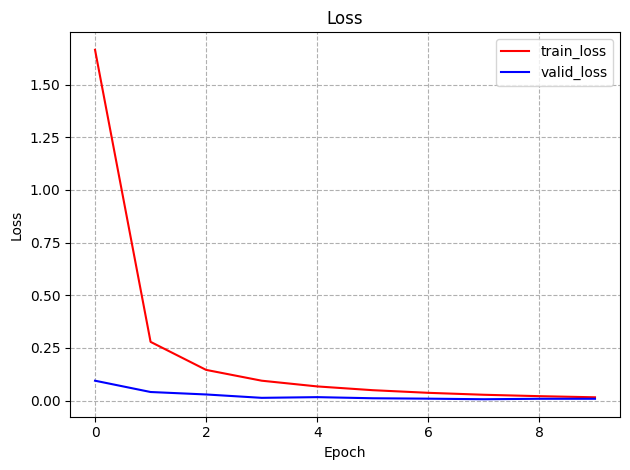

In [19]:
print(f'train_dataset:{len(train_dataset)}')
print(f'valid_dataset:{len(valid_dataset)}')
train_loss=[1.6655,0.2786,0.1455,0.0942,0.0670,0.0491,0.0366,0.0274,0.0207,0.0154]
valid_loss=[0.0942,0.0405,0.0288,0.0128,0.0161,0.0108,0.0089,0.0061,0.0084,0.0084]

# learning curve- 훈련 손실(training loss) 비교
import matplotlib.pyplot as plt
#import matplotlib.ticker as ticker

plot_name = ['No aug', '50% basic aug',
               '50% CutMIX', '50% MIXUP']

color=['red','blue','green','black']

plt.plot(train_loss,label='train_loss',color='red')
plt.plot(valid_loss,label='valid_loss',color='blue')
plt.legend(loc='upper right')
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.grid(which='both', axis='both', linestyle='--')
#axs[0,1].set_ylim(0.5,0.8)
plt.tight_layout()
plt.show()

In [20]:
# 다음은 학습된 모델의 가중치가 저장된 경로입니다
checkpoint_path = "./checkpoint/model_checkpoint.pth"

# 데이터셋과 모델을 불러옵니다
IMG_SIZE = (100, 32)
BATCH_SIZE = 128

test_dataset = MJDataset(TEST_DATA_PATH,label_converter=label_converter,img_size=IMG_SIZE,character=TARGET_CHARACTERS)
test_loader = DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False,num_workers=2,collate_fn=collate_fn,drop_last=False)

label_converter = LabelConverter(TARGET_CHARACTERS)
num_chars = len(label_converter.character)
print(num_chars)

model_test = CRNN(num_chars=num_chars).to(device)
model_test.load_state_dict(torch.load(checkpoint_path, map_location=device))
model_test.eval()

37


CRNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn6): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=

In [21]:
def decode_greedy(output, label_converter):
    # (T,B,C) -> (B,T) index
    out = output.detach().cpu().numpy()  # (T,B,C)
    argmax = out.argmax(axis=2).transpose()  # (B,T)

    results = []
    for seq in argmax:
        # 연속된 동일 글자(또는 blank=0) 제거 로직을 적용해야
        # CTC 디코딩다운 결과가 나옵니다.
        # 여기서는 간단히 blank(0) 무시하고 연속 제거만 보여줌
        decoded = []
        prev = None
        for idx in seq:
            if idx != 0 and idx != prev:
                decoded.append(idx)
            prev = idx
        # 인덱스를 실제 문자로
        decoded_str = label_converter.decode(decoded).replace('-', '')
        results.append(decoded_str)
    return results

In [22]:
def check_inference(model, dataset, index=5):
    for i in range(index):
        img, encoded_label, label_len, raw_label = dataset[i]  # 단일 데이터
        img_tensor = torch.tensor(img[np.newaxis, ...], dtype=torch.float32).to(device)  # (1,3,32,100)
        output = model(img_tensor)  # (T,1,num_chars)
        # 디코딩
        result_text = decode_greedy(output, label_converter)[0]
        print(f"GT: {raw_label} / Pred: {result_text}")

        # 이미지를 시각화하고 싶으면
        display(Image.fromarray(img.transpose(1,2,0).astype(np.uint8)))

GT: SLINKING / Pred: SLINKINGG


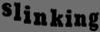

GT: REMODELERS / Pred: REMODELERS


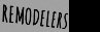

GT: CHRONOGRAPHS / Pred: CHNONOGRAPHS


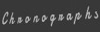

GT: IMPEACHING / Pred: IMPEACHINGG


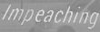

GT: DISCOMBOBULATED / Pred: DISCAMBATULETED


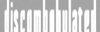

GT: LOOTS / Pred: LOOTS


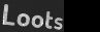

GT: UNDERPAYS / Pred: UNDERPAYSS


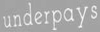

GT: FLAMEPROOFED / Pred: FINGPROIAD


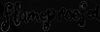

GT: ENTICEMENTS / Pred: ENTICEMIENTS


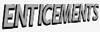

GT: UKASE / Pred: UKASE


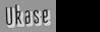

In [23]:
check_inference(model_test, test_dataset, index=10)

### 9. 프로젝트: End-to-End OCR


In [24]:
import os
import numpy as np
from PIL import Image, ImageDraw
import cv2

print("NumPy:", np.__version__)
print("PIL:", Image.__version__)
print("OpenCV:", cv2.__version__)

NumPy: 2.2.6
PIL: 12.0.0
OpenCV: 4.12.0


In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # 0번 GPU만 보이게 설정

import easyocr

print("EasyOCR:", easyocr.__version__)

HOME_DIR = "."

# EasyOCR Reader 생성 (필요한 언어 설정, 예: 영어)
#reader = easyocr.Reader(['en'])
#reader = easyocr.Reader(['en'], gpu=True)
reader = easyocr.Reader(['ko','en'], gpu=True)

SAMPLE_IMG_PATH = HOME_DIR + '/data/sample.jpg'

EasyOCR: 1.7.2


/home/jacksju/anaconda3/envs/case1_study/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:38: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(


In [26]:
def detect_text(img_path):
    # PIL로 이미지 열기
    img_pil = Image.open(img_path).convert('RGB')
    # EasyOCR은 numpy 배열을 입력받으므로 변환
    img_np = np.array(img_pil)

    # EasyOCR을 이용한 텍스트 검출 및 인식
    # 결과 형식: [(bbox, text, confidence), ...]
    ocr_result = reader.readtext(img_np)

    # 시각화를 위해 ImageDraw 객체 생성
    img_draw = ImageDraw.Draw(img_pil)
    cropped_imgs = []

    for bbox, text, conf in ocr_result:
        # 좌표를 정수형으로 변환
        bbox_int = [(int(x), int(y)) for x, y in bbox]
        img_draw.polygon(bbox_int, outline='red')

        xs = [pt[0] for pt in bbox_int]
        ys = [pt[1] for pt in bbox_int]
        x_min = max(0, min(xs) - 5)
        y_min = max(0, min(ys) - 5)
        x_max = max(xs) + 5
        y_max = max(ys) + 5
        word_box = (x_min, y_min, x_max, y_max)
        cropped_imgs.append(img_pil.crop(word_box))

    return img_pil, cropped_imgs, ocr_result

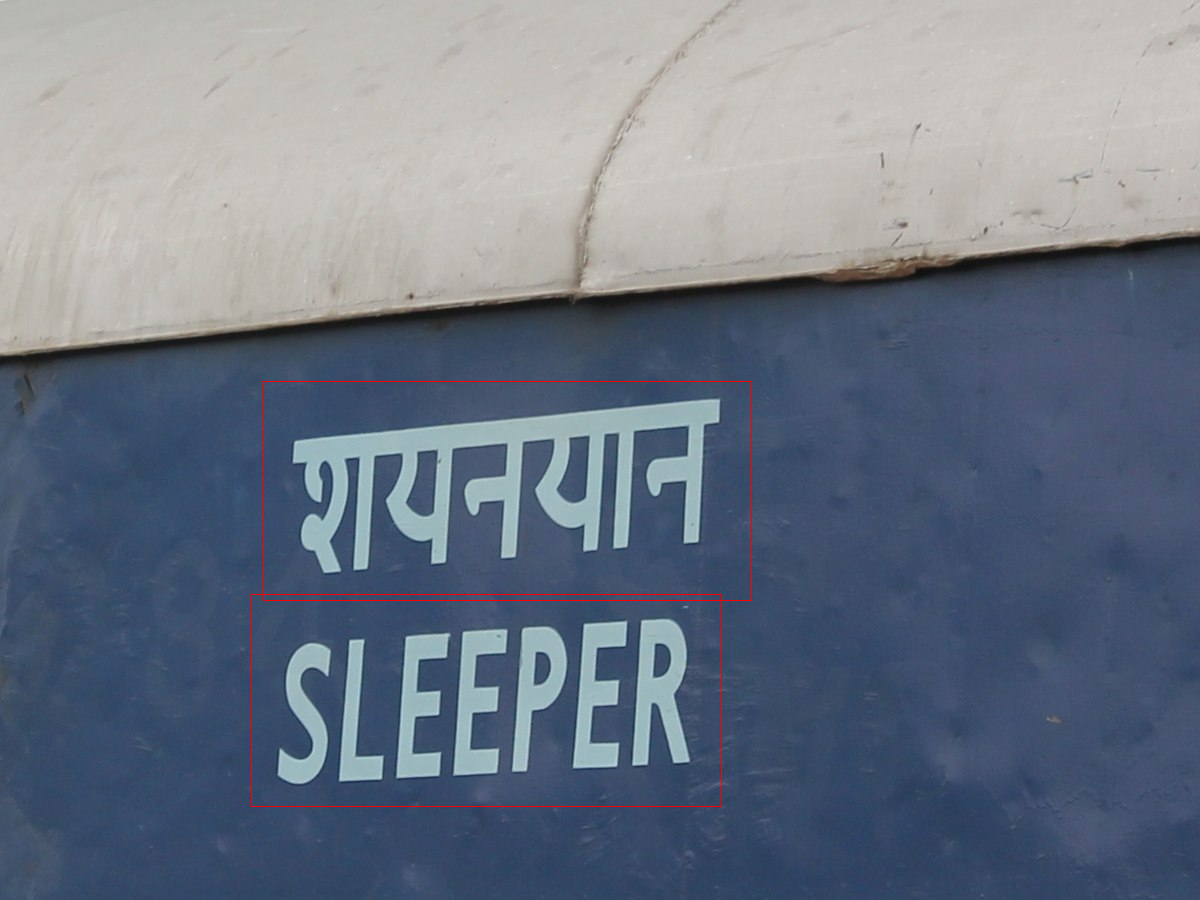

In [27]:
img_pil, cropped_imgs, ocr_result = detect_text(SAMPLE_IMG_PATH)
img_pil

In [28]:
def recognize_img(pil_img, input_img_size=(100, 32)):
    # TODO: 잘려진 단어 이미지를 인식하는 코드를 작성하세요!

    # PIL 이미지를 numpy 배열로 변환
    img_np = np.array(pil_img)
    # 인식 모델 입력 크기에 맞게 이미지 크기 조정
    img_resized = cv2.resize(img_np, input_img_size)

    # detail=0 옵션은 인식 결과의 텍스트만 반환합니다.
    result = reader.readtext(img_resized, detail=0, paragraph=False)

    if result:
        recognized_text = result[0]
    else:
        recognized_text = ""

    print("Recognized text:", recognized_text)
    return recognized_text

In [29]:
for idx, word_img in enumerate(cropped_imgs):
    print(f"[{idx}] ", end="")
    recognize_img(word_img)

[0] Recognized text: 끼i터존다
[1] Recognized text: SLEEPER


## ===================================================================================<br>
## Trained Model 과 EasyOCR 비교<br>
## ===================================================================================<br>

Pred: ES


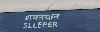

Pred: SLEEPERS


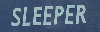

Pred: BEAADLIAPIEDD


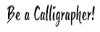

In [57]:
IMG_SIZE = (100, 32)

def process_image(img_path):
    target_w, target_h = IMG_SIZE #목표 크기
    img = cv2.imread(img_path) #(H, W, C)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)#(BGR -> RGB)
    # 리사이즈 (cv2.resize는 (W, H) 순서로 입력받음)
    # 결과 shape: (32, 100, 3) -> (H, W, C)
    img_resized = cv2.resize(img, (target_w, target_h))
    
    # 차원 변경: (H, W, C) -> (C, H, W)
    result_img = img_resized.transpose(2, 0, 1)
   
    return result_img

def check_inference(model, npimg):
    img_tensor = torch.tensor(npimg[np.newaxis, ...], dtype=torch.float32).to(device)  # (1,3,32,100)
    output = model(img_tensor)  # (T,1,num_chars)
    
    result_text = decode_greedy(output, label_converter)[0]# 디코딩
    print(f"Pred: {result_text}")

    display(Image.fromarray(img.transpose(1,2,0).astype(np.uint8)))# 이미지를 시각화

# 실행 예시
for i in range(3):
    SAMPLE_IMG_PATH = f'./data/custom_test_img/sample{i}.jpg'
    #print(SAMPLE_IMG_PATH)
    img = process_image(SAMPLE_IMG_PATH)

    checkpoint_path = "./checkpoint/model_checkpoint.pth"

    label_converter = LabelConverter(TARGET_CHARACTERS)
    num_chars = len(label_converter.character)
    model_test = CRNN(num_chars=num_chars).to(device)
    model_test.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model_test.eval()

    check_inference(model_test, img)

/home/jacksju/anaconda3/envs/case1_study/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:38: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(


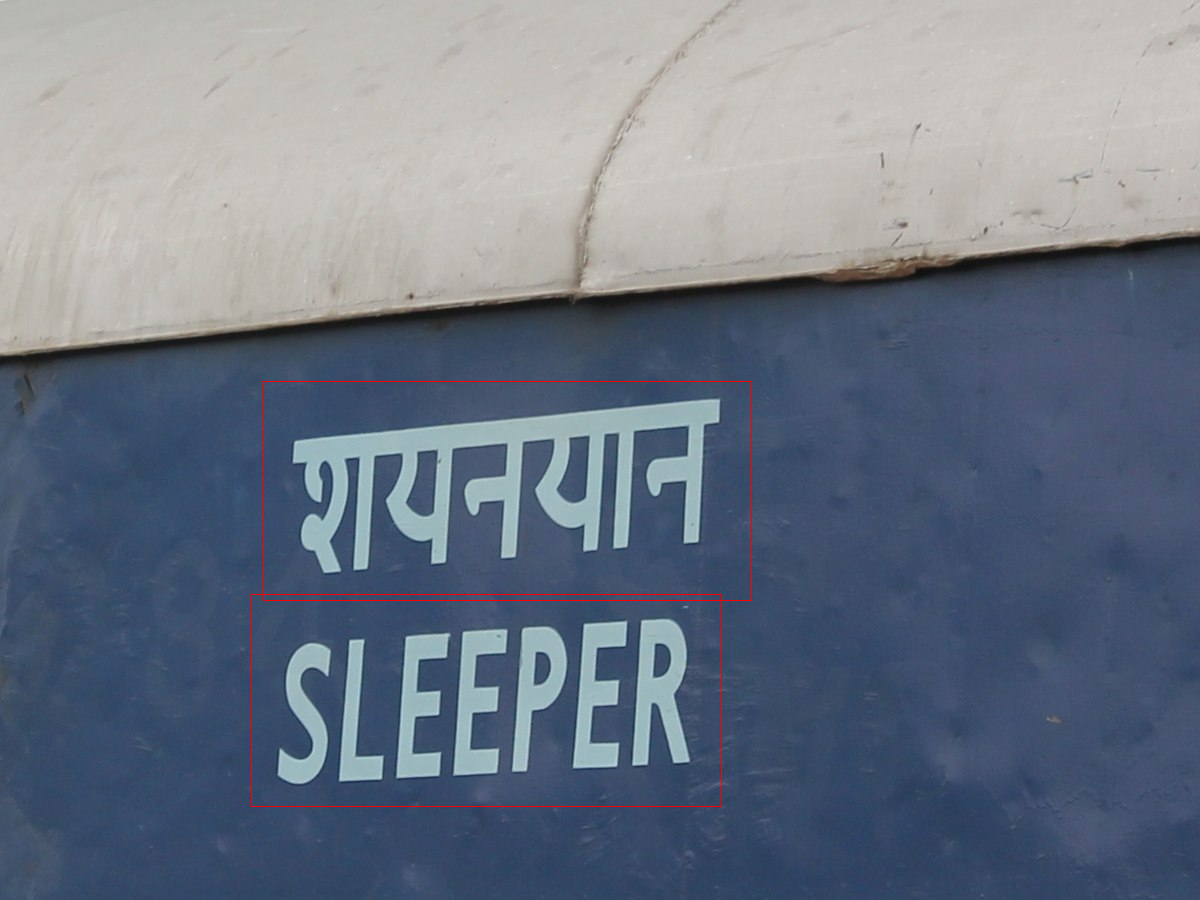

[0] Recognized text: PI4741T
[1] Recognized text: SLEEPER


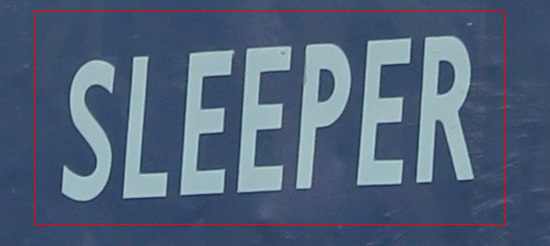

[0] Recognized text: SLEEPER


[0] Recognized text: B2
[1] Recognized text: Calligrapherl


In [61]:
reader = easyocr.Reader(['en'], gpu=True)
for i in range(3):
    SAMPLE_IMG_PATH = f'./data/custom_test_img/sample{i}.jpg'
    img_pil, cropped_imgs, ocr_result = detect_text(SAMPLE_IMG_PATH)
    display(img_pil)
    for idx, word_img in enumerate(cropped_imgs):
        print(f"[{idx}] ", end="")
        recognize_img(word_img)

/home/jacksju/anaconda3/envs/case1_study/lib/python3.12/site-packages/torch/nn/parallel/data_parallel.py:38: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(


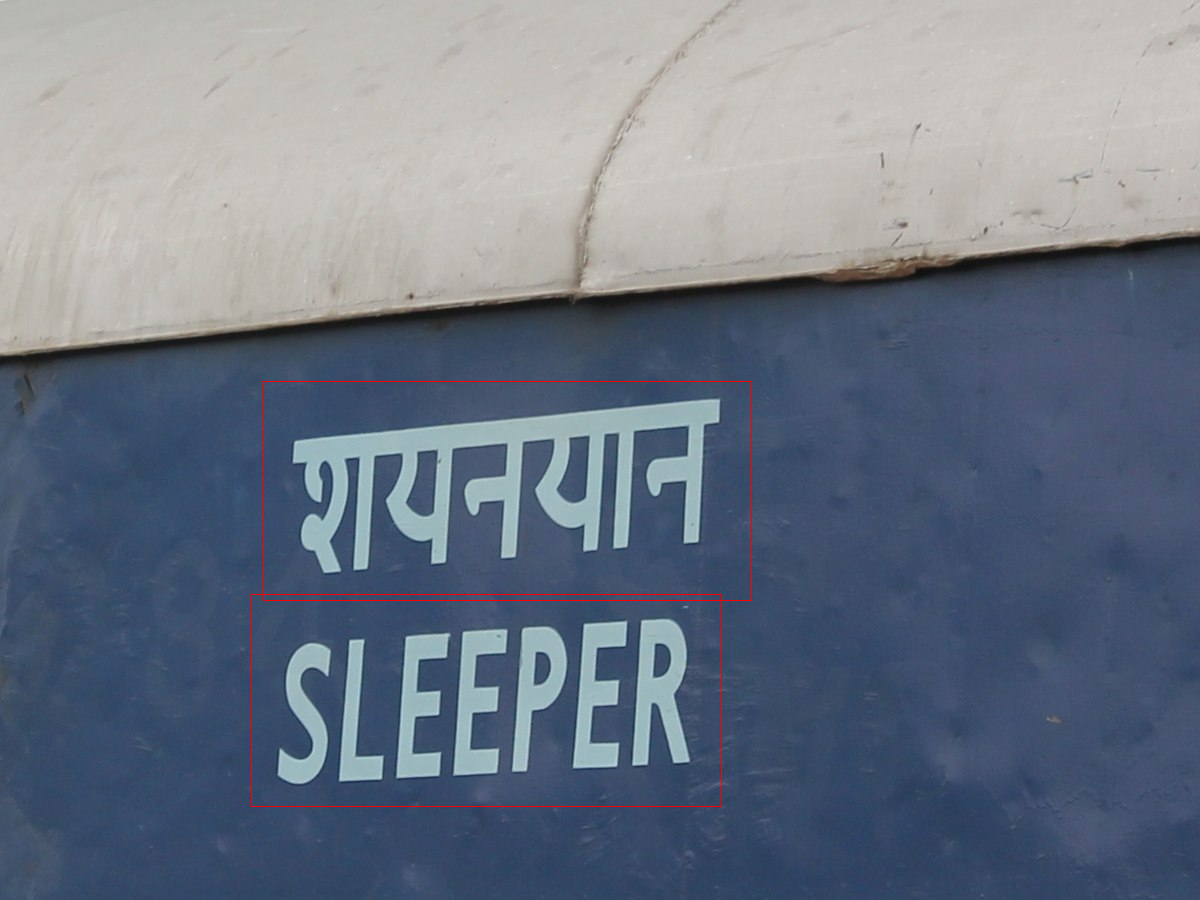

[0] Recognized text: 끼i터존다
[1] Recognized text: SLEEPER


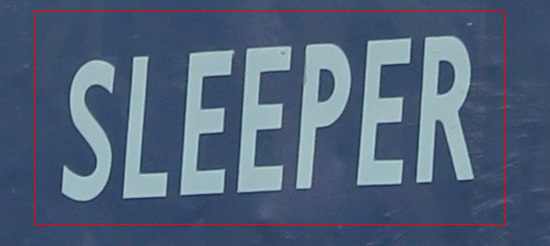

[0] Recognized text: SLEEPER


[0] Recognized text: 목e
[1] Recognized text: [Calligrapliery


In [63]:
reader = easyocr.Reader(['ko','en'], gpu=True)
for i in range(3):
    SAMPLE_IMG_PATH = f'./data/custom_test_img/sample{i}.jpg'
    img_pil, cropped_imgs, ocr_result = detect_text(SAMPLE_IMG_PATH)
    display(img_pil)
    for idx, word_img in enumerate(cropped_imgs):
        print(f"[{idx}] ", end="")
        recognize_img(word_img)

## <후기 및 고찰>
[후기]  
시간 관계상 실험을 하다가.. 시간 부족.. 고찰을 쓰다가.. 시간이 부족..... ㅠㅠ  
좀 더 다양한 데이터로 결과를 분석해보고 싶었으나,  
dataloader 설정/실험에 시간을 많이 할애해서 데이터 비교/분석 시간이 많이 부족한 점이 아쉽다.  

[고찰]  
1. DataLoader setting 실험  
     상세한 실험 기록은 하단 셀에 별도 기록함  
     [결론]  
     a. 기존 방법은 dataset 에서 1-batch를 꺼내오는 시간이 너무 오래 걸림(1~3초)  
     b. sampler를 custom 설계함. dataset을 block단위로 나누고 block안에서 shuffle처리.  
          - 전체 shuffle을 하면 HDD에서 데이터를 읽을 때, 캐시에 전체 데이터를 기준으로 랜덤 데이터가 계속오르내리면서 캐시가 가득차 느려진다고 결론.  
          - block 단위로 shuffle을 하므로 캐시에 데이터가 오르내리는 텀을 줄임(되도록 캐시 내에서 랜덤처리)  
          - block 단위로 shuffle을 하므로 전체 데이터 랜덤성을 떨어지지만 block의 크기를 적절히 잡으면 sub-random으로 충분 하다고 판단함.  
          - block size를 키우면 random성은 올라가지만 캐시 문제가 다시 생길 수 있으므로 DataLoader에서 batch 추출 실험을 통해 추출 속도를 지켜보고 적절한 block size를 결정함  
     c. sampler를 custom 설계한 후 num_workers가 제대로 동작함. num_workers=3  
     d. batch size = 1600  
     e. pin_memory=True, persistent_workers=True, prefetch_factor=4  
     f. 최종 결과 data 이동 속도는 매우 빨라짐 (Batch size:1600, 2080ti 기준)  
          - DataLoader에서 1 batch를 추출해서 GPU에 올리기 까지 걸리는 시간: 0.009초  
          - 하지만, batch size가 늘어난 만큰 GPU 연산시간도 길어짐: 1 batch 학습 연산시간 0.507초  
          - 그러나, 전체 dataset을 고려하면 batch size를 늘이는 것이 이득임.  

2. CRNN 학습 고찰  
     - Loss 그래프를 보면 vaild loss가 train loss보다 계속 낮게 나온다.  
     - 이는, train data가 vaild data에 비해서 매우 방대하여 vaild data 분포가 train data 분포에 속해서 그런 것으로 보인다.  
     - 그렇다고 학습이 나쁘다고는 할 수 없는건 그만큼 train data가 모분포를 잘 나타낸다고 볼 수 있기 때문이다.
     - 하지만, vaild data를 좀 더 넓은 분포에서 확보할 필요는 있다고 생각된다.  

3. CRNN 모델 테스트(test_dataset 사용)  
     - 최종 feature map의 높이를 1로 만들어 순차적으로 입력으로 들어간다. 따라서, receptive field에서 겹치는 영역이 나온다.  
     - 결과적으로 GT: IMPEACHING / Pred: IMPEACHINGG 처럼 중복되는 문자가 출력되는 경우가 생긴다.  
     - 이를 해결하는 방법으로는 추가 레이어를 쌓아서 중복을 제거하는 학습을 하는 등의 방법 또는 CTC 디코딩을 수정하는 방법을 생각해본다.. 상세한 고민은 시간 관계상 줄인다..  

4. CRNN과 EasyOCR 비교 테스트 (custom img 사용)  
     - 본 실험에서 사용한 CRNN 모델은 detection이 포함되지 않고 높이 32픽셀의 이미지 크기에 적합하게 만들어졌다.  
     - 따라서, 이미지에 여러 단어 줄이 있으면 추출이 어렵다.  
     - 또한, 영문자와 숫자에 대해서만 학습되었으므로 이외의 단어가 들어오면 추출이 어렵다.  
     - 반면 EasyOCR은 detection이 함께 수행되고 여러 언어에 대응할 수 있게 만들어져 있다.  
     - 그래서 여러 단어 줄이 있어도 추출이 가능하지만,  
     - 여러 언어가 함께 있을 때, 예를 들어 영어지만 한글로 추출하는 경우도 생긴다.  

## <DataLoader setting 실험 기록>

실험 공통 옵션(별도 언급이 없으면 BATCH_SIZE = 128)  

<실험1> dataset 소요 시간 측정  
{결과} 1개 dataset load 소요 시간: 0.00056초  
#---------------  
[결론] dataset은 이상없음  
시간 소요 매우 적음  
예상: 1 batch 꺼내는 시간은 0.00056x128 = 0.07168초 이상(Shuffle 없을 때)  
#=========================================  

<실험2> collate 소요 시간 측정  
{결과} 1개 batch, collate 소요 시간: 0.00247초  
#---------------  
[결론] collate은 이상없음  
1batch 처리하는데 시간 소요 매우 적음  
#=========================================  

<실험3> 1개 batch load(dataloader) 시간 측정  
\<setting> Dataloader[shuffle=False, num_workers=0/2/4]  
{결과}  
workers0: 소요 시간: 0.02746초 ---> 실험1 예상 0.07168초 보다 빠름  
workers2: 소요 시간: 0.19759초  
workers4: 소요 시간: 0.22870초  
#---------------  
\<setting> Dataloader[shuffle=Ture, num_workers=0/2/4]  
{결과}  
workers0: 소요 시간: 1.46937초  
workers2: 소요 시간: 1.81552초  
workers4: 소요 시간: 2.15812초  
#---------------  
[결론] num_workers=0 로 세팅이 정답 -----------(setting 결론1)  
이유 추측:  
아직 셔플의 시간 소요는 모름  
Dataloader의 shuffle은 epoch마다 1번 수행됨  
#=========================================  

<실험4> 3 batch load(dataloader) 시간 측정  
\<setting> Dataloader[shuffle=False, num_workers=0]  
{결과}  
1st batch 소요 시간: 0.03221초  
2nd batch 소요 시간: 0.02837초  
3rd batch 소요 시간: 0.02845초  
#---------------  
\<setting> Dataloader[shuffle=True, num_workers=0]  
{결과}  
1st batch 소요 시간: 1.45709초  
2nd batch 소요 시간: 0.34448초  
3rd batch 소요 시간: 0.36698초  
#---------------  
[결론] Dataloader의 shuffle에 문제가 있다. -----------(setting 결론2)  
Shuffle은 매 epoch마다 1번 수행되므로  
첫번째 출력은 시간차이가 있더라도  
"두번째 출력부터는 시간차이가 없어야 한다."  
그런데 10배 이상 차이가 난다.  
(추가) shuffle에 소요되는 시간 (1.45709-0.34448 = 1.11261초)  
#=========================================  

<실험5>  
\<setting>  
1. shuffle 함수를 따로 만들고 pipe line으로 연결.  
2. Dataloader[shuffle=False, num_workers=0]  

#---------------  
{결과}  
초반에 빠르다가 일정 batch를 뽑고나면 다시 느려짐 (폐기)  
#=========================================  

<실험6>  
\<setting>  
1. random_split 함수 사용, 한쪽으로 데이터 몰아주기  
2. 매 epoch 마다 random_split 으로 dataset 생성, DataLoader 재생성  
3. Dataloader[shuffle=False, num_workers=0]  
(참고) random_split은 내부적으로 전체 데이터를 섞은 후  
      앞에서 부터 일정 데이터를 잘라서 test, vaild로 나눈다.  

#---------------  
{결과}  
초반에 빠르다가 일정 batch를 뽑고나면 다시 느려짐 (폐기)  
#=========================================  

<실험7> -LLM  
랜덤 접근 + 디스크/LMDB 캐시 붕괴 쪽 문제  
\<setting>  
Block Shuffle Sampler 아이디어  
아이디어:  
전체 인덱스를 큰 블록으로 나누고  
각 블록 안에서만 랜덤하게 섞기  
블록 자체는 0,1,2,3 순서대로 진행  
디스크 입장에서는  
여전히 대체로 비슷한 영역을 한 덩어리씩 읽게 돼서  
완전 랜덤에 비해 seek가 줄어들고  
학습 입장에서는  
최소한 “블록 내부”에서는 순서가 뒤집혀 있어서  
어느 정도 랜덤성이 확보된다.  
랜덤성만 보면: block_size ↑  
LMDB + HDD I/O를 버티게 하려면: block_size ↓  
#---------------  
{결과}&[결론]  
결과를 캡쳐 못했다...  
하지만,  
<실험4> 의 shuffle=False 속도 만큼 나오는걸 확인했음  
그리고 num_workers=3 까지 속도가 잘 나오는 것을 확인함 -----------(setting 결론3)  
#=========================================  

<실험8>  
Batch size와 실제 GPU에 올라가서 연산하는 시간 비교  
\<setting>&{결과}  
Batch size 128  
시간1: 0.00362초 // 시간2: 0.00121초 // 시간3: 0.04225초  
시간1: 0.00381초 // 시간2: 0.00128초 // 시간3: 0.04264초  ->(0.00381+0.00128+0.04264)*56442/60=44분  
시간1: 0.00358초 // 시간2: 0.00145초 // 시간3: 0.04247초  
#---------------  
Batch size 1600  
시간1: 0.01684초 // 시간2: 0.01187초 // 시간3: 0.51409초  
시간1: 0.02048초 // 시간2: 0.01471초 // 시간3: 0.51511초  ->(0.02048+0.01471+0.51511)*4515/60=41.41분  
시간1: 0.02030초 // 시간2: 0.01477초 // 시간3: 0.51721초  
#---------------  
시간1: train_loader에서 1 batch를 뽑는 시간  
시간2: 1 batch를 gpu에 올리는 시간  
시간3: model ouput, loss, backward, opimizer.step(), train_loss 총합 구하기 까지 모든 학습 시간  
#---------------  
[결론]  
GPU 연산은 병렬 연산이기에 Batch size가 늘어도 GPU연산시간(시간3)에는  
큰 차이가 없을 것이라 생각했으나, 차이가 있다.  
그 이유는 아래와 같이 예상된다.  
1. GPU 코어 포화 - GPU 코아 수 보다 처리해야 할 데이터가 많아지는 경우, 순차저긍로 처리해야 함  
2. 총 연상량 증가 - 데이터가 수배/수십배로 늘면 forward/backward 총 연산량도 늘어나므로  
하지만, Batch size를 늘리는 것이 1 batch size의 연산량은 늘어나지만, -----------(setting 결론4)  
1 epoch를 처리하는 시간은 줄어들기 때문에 이득이 있다.  
<실험 8>에 따르면, batch size가 128 -> 1600 으로 늘면 1 epoch당 2~3분의 이득이 있는것으로 보인다.  

#=========================================  
<실험9>  
DataLoader의 parameter 추가 수정  
pin_memory=True  
- CPU의 데이터를 GPU로 전송하는 속도를 높임.  
- DataLoader가 데이터를 읽어올 때 아예 Pinned Memory 영역에 데이터를 할당함.  
  이렇게 하면 GPU로 전송할 때 임시 공간을 거치지 않고  
- Direct Memory Access (DMA)**를 통해 바로 쏠 수 있어 전송 속도가 빨라짐.  

persistent_workers=True  
- 워커를 유지하여 Epoch(에폭)이 끝날 때마다 발생하는 오버헤드를 줄임  
- False(기본값): 한 에폭(Epoch)이 끝나면 데이터를 로드하던 워커 프로세스들을 모두 종료(Destroy)하고,  
  다음 에폭 시작 때 다시 생성(Respawn)하는데, 프로세스를 끄고 켜는 비용이 꽤 큼  
- True: 에폭이 끝나도 워커 프로세스를 종료하지 않고 계속 살려둠  
- 에폭과 에폭 사이의 준비 시간(Latency)이 거의 사라짐  
- 전체 데이터셋 크기가 작거나, 에폭을 매우 빠르게 도는 경우 특히 True가 추천됨  

prefetch_factor=4  
- GPU가 다음 배치를 기다리지 않도록 미리 데이터를 로드  
- GPU가 현재 배치를 학습하는 동안 CPU는 놀지 않고 다음 배치를 준비함  
- 워커(Worker) 프로세스가 몇 개의 배치(Batch)를 미리 로드해서 대기시킬지 결정  
- num_workers=3, prefetch_factor=4라면, 총 3x4 = 12개의 배치가 미리 준비되어 메모리에 대기  
- 기본값은 2로 설정되어 있음  

#---------------  
\<setting>  
Batch size 1600  
pin_memory=True, persistent_workers=True, prefetch_factor=4  -----------(setting 결론5)  
#---------------  
{결과}  
시간1: 0.00342초 // 시간2: 0.00516초 // 시간3: 0.50795초  -> (0.00342+0.00516+0.50795)*4515/60 = 38분  
시간1: 0.00033초 // 시간2: 0.00660초 // 시간3: 0.50775초  
시간1: 0.00045초 // 시간2: 0.00531초 // 시간3: 0.50651초  
시간1: 0.00031초 // 시간2: 0.00533초 // 시간3: 0.50758초  
시간1: 0.00035초 // 시간2: 0.00516초 // 시간3: 0.50829초  
#---------------  
시간1: train_loader에서 1 batch를 뽑는 시간  
시간2: 1 batch를 gpu에 올리는 시간  
시간3: model ouput, loss, backward, opimizer.step(), train_loss 총합 구하기 까지 모든 학습 시간  
#---------------  
[결론]  
앞의 <실험8> 결과와 비교해보면 데이터를 이동하는 시간은 매우 크게 줄었다.(10~100배 개선)  
하지만, GPU연산 시간은 크게 차이가 없는것을 확인할 수 있다.  
이는 dataloader 옵션이 데이터를 이동하는데 관련된 옵션이기 때문이다.  
따라서, 데이터를 이동하는 시간은 크게 줄었으나, GPU연산 시간이 기여하는 부분이 크므로  
전체 시간은 약간 감소하는 것으로 확인된다. (1batch 당 약 3~4분)  